In [2]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf

from warnings import filterwarnings
filterwarnings('ignore')

from pycaret.classification import *
import gc
from sklearn.metrics import *
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.compose import make_column_transformer


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
import re
import os
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# data load

In [3]:
PATH = 'data/'
li = os.listdir(PATH)
li

['sample_submission.csv',
 'test_err_data.csv',
 'test_quality_data.csv',
 'train_err_data.csv',
 'train_problem_data.csv',
 'train_quality_data.csv',
 'Z_summary.txt',
 'Z_test_summary.csv',
 'Z_train_summary.csv']

In [6]:
train_summary = pd.read_csv(PATH + li[-1],index_col=0)
test_summary = pd.read_csv(PATH + li[-2],index_col=0)

In [8]:
train_summary.head(5)

,user_id,problem,start_t_errlog,rec_t_problem,time_interval_hour,n_errlogs,model,n_models,fwver,n_fwvers,errtype,n_errtypes
0,10000,0.0,2020-11-01 02:56:16,-1,-1,317,['model_3'],1,['05.15.2138'],1,[15 12 11 16 4 26 10 14 3 13 6 7 27 28],14
1,10001,1.0,2020-11-01 02:04:15,2020-11-13T19:00:00.000000000,"(304.0,)",2365,['model_2'],1,['04.33.1185' '04.33.1261'],2,[15 31 33 12 11 22 26 16 41 5 14 40 34 13 6 ...,26
2,10002,0.0,2020-11-01 03:02:51,-1,-1,306,['model_3'],1,['05.15.2138'],1,[11 12 16 4 26 15 24 27 28 13 3 7 6 14 5 10],16
3,10003,0.0,2020-11-01 18:25:32,-1,-1,306,['model_2'],1,['04.33.1185' '04.33.1261'],2,[15 16 31 40 22 23 26 6 7 5 17 38 33 12 11 ...,18
4,10004,1.0,2020-11-01 02:46:47,2020-11-04T12:00:00.000000000,"(81.0,)",777,['model_0'],1,['04.22.1750' '04.22.1778'],2,[13 12 14 6 7 15 33 11 22 26 16 31 23 40 4 ...,18


In [9]:
print(train_summary.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             15000 non-null  int64  
 1   problem             15000 non-null  float64
 2   start_t_errlog      15000 non-null  object 
 3   rec_t_problem       15000 non-null  object 
 4   time_interval_hour  15000 non-null  object 
 5   n_errlogs           15000 non-null  int64  
 6   model               15000 non-null  object 
 7   n_models            15000 non-null  int64  
 8   fwver               15000 non-null  object 
 9   n_fwvers            15000 non-null  int64  
 10  errtype             15000 non-null  object 
 11  n_errtypes          15000 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 1.5+ MB
None


In [10]:
test_summary.head(5)

,user_id,start_t_errlog,n_errlogs,model,n_models,fwver,n_fwvers,errtype,n_errtypes
0,30000,2020-11-01 03:02:27,2750,['model_1' 'model_2'],2,['04.16.3553' '04.16.3571' '04.33.1261'],3,[31 33 15 22 11 12 23 26 16 17 5 39 24 40 36 ...,25
1,30001,2020-11-01 04:21:35,284,['model_3'],1,['05.15.2138'],1,[11 12 4 16 26 15 3 13 7 6 14 5 27 28],14
2,30002,2020-11-01 00:36:16,941,['model_0'],1,['04.22.1750' '04.22.1778'],2,[26 15 33 11 12 22 16 40 31 24 39 23 5 14 6 ...,20
3,30003,2020-11-01 22:02:05,371,['model_0'],1,['04.22.1750' '04.22.1778'],2,[31 41 40 16 15 34 33 11 12 5 6 7 14 22 26 ...,24
4,30004,2020-11-01 00:31:30,881,['model_1' 'model_2'],2,['04.16.3553' '04.33.1149' '04.33.1261'],3,[31 41 32 40 15 33 11 12 16 17 5 4 38 27 28 ...,26


In [11]:
print(test_summary.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14999 entries, 0 to 14998
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         14999 non-null  int64 
 1   start_t_errlog  14999 non-null  object
 2   n_errlogs       14999 non-null  int64 
 3   model           14999 non-null  object
 4   n_models        14999 non-null  int64 
 5   fwver           14999 non-null  object
 6   n_fwvers        14999 non-null  int64 
 7   errtype         14999 non-null  object
 8   n_errtypes      14999 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 1.1+ MB
None


# train summary의 problem을 0과 1로 나눠서 살펴보기

In [12]:
# problem == 0
train0 = train_summary[train_summary['problem']==0]
train0

,user_id,problem,start_t_errlog,rec_t_problem,time_interval_hour,n_errlogs,model,n_models,fwver,n_fwvers,errtype,n_errtypes
0,10000,0.0,2020-11-01 02:56:16,-1,-1,317,['model_3'],1,['05.15.2138'],1,[15 12 11 16 4 26 10 14 3 13 6 7 27 28],14
2,10002,0.0,2020-11-01 03:02:51,-1,-1,306,['model_3'],1,['05.15.2138'],1,[11 12 16 4 26 15 24 27 28 13 3 7 6 14 5 10],16
3,10003,0.0,2020-11-01 18:25:32,-1,-1,306,['model_2'],1,['04.33.1185' '04.33.1261'],2,[15 16 31 40 22 23 26 6 7 5 17 38 33 12 11 ...,18
7,10007,0.0,2020-11-01 03:03:42,-1,-1,153,['model_0'],1,['04.22.1750' '04.22.1778'],2,[15 33 12 11 22 23 36 37 42],9
10,10010,0.0,2020-11-01 00:14:36,-1,-1,7511,['model_1'],1,['04.16.3553'],1,[26 23 22 16 31 15 33 11 12 5 17 32 41 4 40],15
...,...,...,...,...,...,...,...,...,...,...,...,...
14993,24993,0.0,2020-11-01 00:39:47,-1,-1,556,['model_3'],1,['05.15.2138'],1,[15 26 16 4 11 12 5 24],8
14994,24994,0.0,2020-11-01 22:41:03,-1,-1,281,['model_3'],1,['05.15.2138'],1,[16 4 26 15 12 11 3 14 6 7 5 24],12
14995,24995,0.0,2020-11-20 18:18:35,-1,-1,194,['model_2'],1,['04.33.1261'],1,[33 11 12 22 26 41 15 16 31 5 40 23 13 6 14 ...,17
14996,24996,0.0,2020-11-30 16:25:11,-1,-1,4,['model_3'],1,['05.15.2138'],1,[26 11 12 30],4


In [85]:
train0.describe()

,user_id,problem,n_errlogs,n_models,n_fwvers,n_errtypes
count,10000.000000,10000.0,10000.00000,10000.000000,10000.000000,10000.000000
mean,17473.668400,0.0,896.58820,1.006100,1.523200,14.050500
std,4330.083896,0.0,2665.05613,0.079142,0.511554,4.494082
min,10000.000000,0.0,1.00000,1.000000,1.000000,1.000000
25%,13746.750000,0.0,335.00000,1.000000,1.000000,11.000000
50%,17462.500000,0.0,577.00000,1.000000,2.000000,14.000000
75%,21192.750000,0.0,906.00000,1.000000,2.000000,17.000000
max,24999.000000,0.0,195538.00000,3.000000,4.000000,28.000000


In [30]:
# problem == 1
train1 = train_summary[train_summary['problem']==1]
train1

,user_id,problem,start_t_errlog,rec_t_problem,time_interval_hour,n_errlogs,model,n_models,fwver,n_fwvers,errtype,n_errtypes
1,10001,1.0,2020-11-01 02:04:15,2020-11-13T19:00:00.000000000,"(304.0,)",2365,['model_2'],1,['04.33.1185' '04.33.1261'],2,[15 31 33 12 11 22 26 16 41 5 14 40 34 13 6 ...,26
4,10004,1.0,2020-11-01 02:46:47,2020-11-04T12:00:00.000000000,"(81.0,)",777,['model_0'],1,['04.22.1750' '04.22.1778'],2,[13 12 14 6 7 15 33 11 22 26 16 31 23 40 4 ...,18
5,10005,1.0,2020-11-01 00:02:19,2020-11-13T12:00:00.000000000,"(299.0,)",749,['model_0'],1,['04.22.1750' '04.22.1778'],2,[26 15 16 31 41 5 23 22 40 33 11 12 24 4 34 ...,25
6,10006,1.0,2020-11-01 04:26:40,2020-11-10T17:00:00.000000000,"(228.0,)",490,['model_1' 'model_2'],2,['04.16.3553' '04.33.1261'],2,[15 16 31 17 33 11 12 5 34 35 6 7 14 4 36 ...,17
8,10008,1.0,2020-11-02 04:31:07,2020-11-24T13:00:00.000000000,"(536.0,)",124,['model_0'],1,['04.22.1750' '04.22.1778'],2,[15 33 22 12 11 36 37 23 42],9
...,...,...,...,...,...,...,...,...,...,...,...,...
14983,24983,1.0,2020-11-01 00:23:37,2020-11-23T22:00:00.000000000,"(549.0,)",341,['model_0'],1,['04.22.1750' '04.22.1778'],2,[26 16 31 15 33 12 11 22 23 4 40 7 18 20 14 ...,19
14984,24984,1.0,2020-11-01 00:09:48,2020-11-30T15:00:00.000000000,"(710.0,)",5554,['model_1' 'model_2'],2,['04.16.3553' '04.33.1261'],2,[26 15 32 33 31 12 11 22 16 23 40 17 5 13 14 ...,22
14990,24990,1.0,2020-11-01 00:11:27,2020-11-21T17:00:00.000000000,"(496.0,)",725,['model_4'],1,['03.11.1167'],1,[15 1 4 11 12 3 6 5 7 28 27 16],12
14997,24997,1.0,2020-11-01 07:16:24,2020-11-15T15:00:00.000000000,"(343.0,)",826,['model_0'],1,['04.22.1750' '04.22.1778'],2,[26 16 31 40 23 22 15 33 11 12 34 13 7 6 14 ...,21


In [86]:
train1.describe()

,user_id,problem,n_errlogs,n_models,n_fwvers,n_errtypes
count,5000.000000,5000.0,5000.000000,5000.00000,5000.000000,5000.000000
mean,17551.163200,1.0,1517.756200,1.12860,1.766000,18.106800
std,4330.617024,0.0,4857.527435,0.33479,0.604084,4.817721
min,10001.000000,1.0,2.000000,1.00000,1.000000,1.000000
25%,13757.500000,1.0,563.000000,1.00000,1.000000,15.000000
50%,17562.500000,1.0,849.000000,1.00000,2.000000,18.000000
75%,21349.000000,1.0,1348.000000,1.00000,2.000000,22.000000
max,24998.000000,1.0,222186.000000,2.00000,4.000000,32.000000


### 결론
- problem==0인 user_id는 5000개, problem==1인 user_id는 10000개로 정확히 2배 차이
- describe()를 살펴본 결과 n_models의 max값이 train0보다 train1이 더 크게 나타난 것이 주목할 점(outlier 여부는 시각화를 통해 판단)

# 시각화(numerical column과 problem사이의 관계)
- seaborn의 relplot 이용
    - scatterplot과 lineplot의 상위 개념의 함수
    - kind='scatter'(default) or 'line'으로 설정해 줄 수 있다
    - line, scatter plot 모두 시각화해보기 위하여 사용하였으나 scatter가 더 한눈에 알아보기 쉬웠음

# 에러로그 수

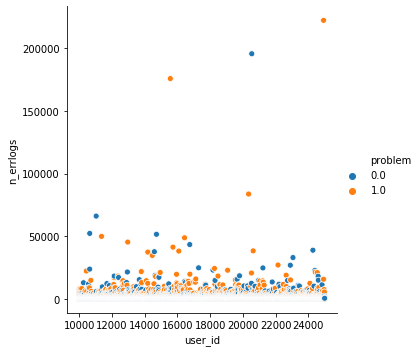

In [54]:
sns.relplot(x='user_id',y='n_errlogs',data=train_summary,hue='problem')
plt.show()

### 결론
- n_errlogs와 problem(불만표출) 사이에는 예상외로 상관관계가 없는 듯
- errlogs의 개수가 적다고 problem제기를 적게하고, errlogs의 개수가 많다고 problem제기를 많이 하는 것이 아님
- errlogs의 개수가 많아도 스스로 고칠 수 있는 정도의 error면 problem제기를 하지 않을 수 있다고 판단

# 모델 수

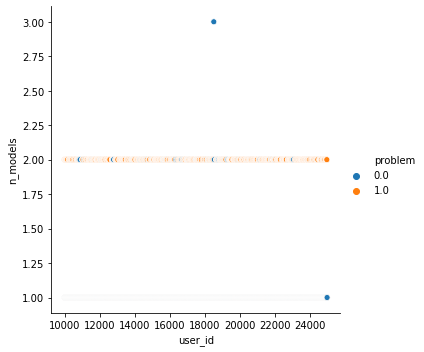

In [55]:
sns.relplot(x='user_id',y='n_models',data=train_summary,hue='problem')
plt.show()

### 결론
- n_models의 값은 2에 몰려있는데 1과 3인 값은 둘 다 problem이 0이지만 케이스가 너무 적어 일반화하긴 무리

# 펌웨어 수

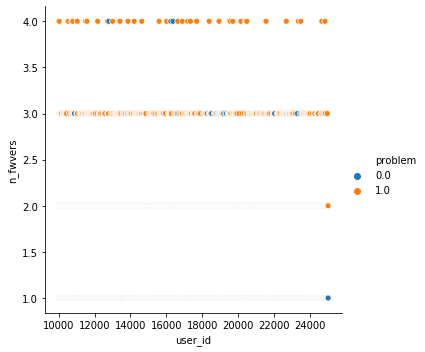

In [56]:
sns.relplot(x='user_id',y='n_fwvers',data=train_summary,hue='problem')
plt.show()

### 결론
- n_fwvers에 따른 두드러진 상관관계는 보이지 않음

# 에러타입 수

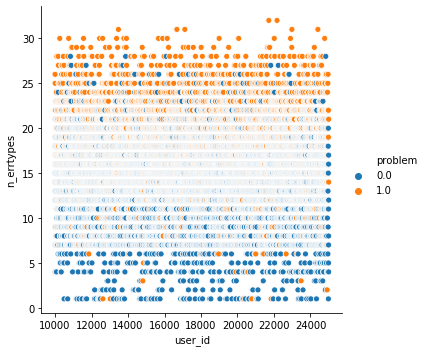

In [57]:
sns.relplot(x='user_id',y='n_errtypes',data=train_summary,hue='problem')
plt.show()

### 결론
- n_errtypes에 따라 problem=1인 값이 위쪽, 0인 값이 아래쪽에 분포하는 경향
- n_errtypes와 problem은 어느정도 상관관계가 있을것으로 예상

### train_summary 컬럼들과 problem의 상관관계 알아보기

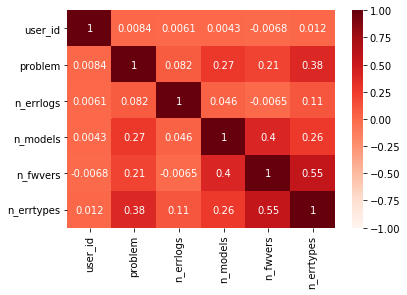

In [8]:
sns.heatmap(train_summary.corr(),annot=True,cmap='Reds',vmin=-1,vmax=1)
plt.show()

### 결론
- problem과 n_errortypes의 상관관계가 가장 높은 것을 알 수 있다
- problem과 n_errlogs의 상관관계는 낮다
- 위에서 시각화로 알아본 결과와 같은 맥락

# numerical column만 추출하여 x_train, x_test 나누기

In [44]:
x_train = train_summary.iloc[:,[5,7,9,11]]
x_train

,n_errlogs,n_models,n_fwvers,n_errtypes
0,317,1,1,14
1,2365,1,2,26
2,306,1,1,16
3,306,1,2,18
4,777,1,2,18
...,...,...,...,...
14995,194,1,1,17
14996,4,1,1,4
14997,826,1,2,21
14998,155,1,2,14


In [33]:
y_train = train_summary.iloc[:,1]
y_train

0        0.0
1        1.0
2        0.0
3        0.0
4        1.0
        ... 
14995    0.0
14996    0.0
14997    1.0
14998    1.0
14999    0.0
Name: problem, Length: 15000, dtype: float64

In [34]:
x_test = test_summary.iloc[:,[2,4,6,8]]
x_test

,n_errlogs,n_models,n_fwvers,n_errtypes
0,2750,2,3,25
1,284,1,1,14
2,941,1,2,20
3,371,1,2,24
4,881,2,3,26
...,...,...,...,...
14994,1115,1,1,19
14995,515,1,2,16
14996,2233,1,2,21
14997,24671,1,2,22


# 다중공선성 확인 및 제거

In [45]:
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(x_train.values,i) for i in range(x_train.shape[1])]
vif['features'] = x_train.columns
vif

,VIF Factor,features
0,1.118447,n_errlogs
1,13.190676,n_models
2,15.156752,n_fwvers
3,14.171352,n_errtypes


In [46]:
# VIF Factor가 가장 높은 feature 선택
vifX = vif.iloc[vif['VIF Factor'].nlargest(1).index].features.values.tolist()
vifX

['n_fwvers']

In [47]:
# VIF Factor가 가장 높은 피쳐 제거
x_train = x_train.drop(columns=vifX)
x_train

,n_errlogs,n_models,n_errtypes
0,317,1,14
1,2365,1,26
2,306,1,16
3,306,1,18
4,777,1,18
...,...,...,...
14995,194,1,17
14996,4,1,4
14997,826,1,21
14998,155,1,14


In [48]:
# VIF 재확인
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(x_train.values,i) for i in range(x_train.shape[1])]
vif['features'] = x_train.columns
vif

,VIF Factor,features
0,1.109044,n_errlogs
1,9.929462,n_models
2,10.028310,n_errtypes


In [49]:
# 다중공선성 확인 후 최종 x_train
x_train

,n_errlogs,n_models,n_errtypes
0,317,1,14
1,2365,1,26
2,306,1,16
3,306,1,18
4,777,1,18
...,...,...,...
14995,194,1,17
14996,4,1,4
14997,826,1,21
14998,155,1,14


# MLP모델

In [14]:
model_pip = make_pipeline( StandardScaler(), MLPClassifier( early_stopping=True) )

hidden_layer_sizes=[[3],[4],[3,3],[3,4],[3,5]]
activation=['relu', 'identity', 'tanh', 'logistic']
solver=['lbfgs', 'sgd', 'adam'] 
alpha=[0.0001,1e-5,0.01,0.001]
batch_size=[1000,5000]
learning_rate=['constant', 'invscaling', 'adaptive'] 
learning_rate_init=[0.001,0.01,0.1,0.2,0.3] 

param_value={'mlpclassifier__hidden_layer_sizes':hidden_layer_sizes, 
                 'mlpclassifier__activation':activation, 
                 'mlpclassifier__batch_size':batch_size,
                'mlpclassifier__learning_rate':learning_rate,
                 'mlpclassifier__learning_rate_init':learning_rate_init}

model_mlp = GridSearchCV(model_pip, param_grid = param_value,scoring='f1')
model_mlp.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('mlpclassifier',
                                        MLPClassifier(early_stopping=True))]),
             param_grid={'mlpclassifier__activation': ['relu', 'identity',
                                                       'tanh', 'logistic'],
                         'mlpclassifier__batch_size': [1000, 5000],
                         'mlpclassifier__hidden_layer_sizes': [[3], [4], [3, 3],
                                                               [3, 4], [3, 5]],
                         'mlpclassifier__learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                         'mlpclassifier__learning_rate_init': [0.001, 0.01, 0.1,
                                                               0.2, 0.3]},
             scoring='f1')

In [15]:
print(model_mlp.best_params_)
print(model_mlp.best_score_)
print(model_mlp.best_estimator_)

{'mlpclassifier__activation': 'relu', 'mlpclassifier__batch_size': 1000, 'mlpclassifier__hidden_layer_sizes': [4], 'mlpclassifier__learning_rate': 'invscaling', 'mlpclassifier__learning_rate_init': 0.1}
0.532032462801159
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(batch_size=1000, early_stopping=True,
                               hidden_layer_sizes=[4],
                               learning_rate='invscaling',
                               learning_rate_init=0.1))])


In [16]:
y_pred_train= model_mlp.best_estimator_.predict(x_train)

In [17]:
print('train 정밀도: ',metrics.precision_score( y_train, y_pred_train ))
print('train 재현율: ',metrics.recall_score( y_train, y_pred_train ))
print('train F1 score: ',metrics.f1_score( y_train, y_pred_train ))
print('train auc score: ',metrics.roc_auc_score( y_train, y_pred_train ))

train 정밀도:  0.7588410737111205
train 재현율:  0.3562
train F1 score:  0.4848237375799646
train auc score:  0.6498


### 결론 
- MLP모델은 auc score(0.6498)가 낮으므로 다른 모델을 사용해보자

# 로지스틱 모델

In [32]:
model_logistic = make_pipeline( StandardScaler(), LogisticRegression() )
param_value = {'logisticregression__C': np.linspace(0,50, 100),'logisticregression__penalty':['l1', 'l2', 'elasticnet', 'none']
              , 'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
model_logistic = GridSearchCV(model_logistic, param_grid = param_value,scoring='f1')
model_logistic.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': array([ 0.        ,  0.50505051,  1.01010101,  1.51515152,  2.02020202,
        2.52525253,  3.03030303,  3.53535354,  4.04040404,  4.54545455,
        5.05050505,  5.55555556,  6.06060606,  6.56565657,  7.07070707,
        7.57575758,  8.08080808,  8.58585...
       40.4040404 , 40.90909091, 41.41414141, 41.91919192, 42.42424242,
       42.92929293, 43.43434343, 43.93939394, 44.44444444, 44.94949495,
       45.45454545, 45.95959596, 46.46464646, 46.96969697, 47.47474747,
       47.97979798, 48.48484848, 48.98989899, 49.49494949, 50.        ]),
                         'logisticregression__penalty': ['l1', 'l2',
                                                         'elasticnet', 'none'],
                         'logisticregression__

In [34]:
print(model_logistic.best_params_)
print(model_logistic.best_score_)
print(model_logistic.best_estimator_)

{'logisticregression__C': 0.0, 'logisticregression__penalty': 'none', 'logisticregression__solver': 'sag'}
0.5109269249006162
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.0, penalty='none', solver='sag'))])


In [42]:
y_pred_train= model_logistic.best_estimator_.predict(x_train)

In [44]:
print('train 정밀도: ',metrics.precision_score( y_train, y_pred_train ))
print('train 재현율: ',metrics.recall_score( y_train, y_pred_train ))
print('train F1 score: ',metrics.f1_score( y_train, y_pred_train ))
print('train auc score: ',metrics.roc_auc_score( y_train, y_pred_train ))

train 정밀도:  0.7069327731092437
train 재현율:  0.4038
train F1 score:  0.5140020366598778
train auc score:  0.66005


In [76]:
y_pred_test = model_logistic.best_estimator_.predict(x_test)

In [77]:
pred_ensemble = model_logistic.predict_proba(x_test)
pred_ensemble[:,1]

array([0.96143275, 0.27293425, 0.45717839, ..., 0.51343628, 0.68357138,
       0.36004253])

In [80]:
sample_submssion = pd.read_csv(PATH+'sample_submission.csv')

In [82]:
sample_submssion['problem'] = pred_ensemble

In [83]:
sample_submssion.to_csv("dacon_baseline.csv", index = False)
sample_submssion

,user_id,problem
0,30000,0.038567
1,30001,0.727066
2,30002,0.542822
3,30003,0.355049
4,30004,0.033308
...,...,...
14994,44994,0.495791
14995,44995,0.723814
14996,44996,0.486564
14997,44997,0.316429


### 결론 
- auc score(0.66005)가 낮지만 결과를 제출형식에 맞게 변환하여 저장해봄
- score가 낮으니 AutoML을 사용해 여러 모델에 적합시켜보자

# Auto ML
- AutoML은 모델링 과정에서 전처리, 모델 학습 및 평가 등 반복적으로 되풀이 되는 일련의 과정을 자동화 해주는 도구
- pycaret은 AutoML을 파이썬에서 사용할 수 있도록 한 오픈소스 라이브러리로 초기 모델을 쉽고 빠르게 결정할 수 있도록 하며, 파라미터 튜닝과 앙상블 등의 기능을 지원

### StandardScaling ver.

In [35]:
# StandardScaler x_test
std_scaler = StandardScaler()
fitted = std_scaler.fit(x_test)
x = std_scaler.transform(x_test)
x_test = pd.DataFrame(x,columns=x_test.columns)
x_test

,n_errlogs,n_models,n_fwvers,n_errtypes
0,0.378831,4.661091,2.498515,1.915913
1,-0.188122,-0.213862,-1.087459,-0.283320
2,-0.037073,-0.213862,0.705528,0.916261
3,-0.168120,-0.213862,0.705528,1.715983
4,-0.050867,4.661091,2.498515,2.115843
...,...,...,...,...
14994,0.002931,-0.213862,-1.087459,0.716331
14995,-0.135013,-0.213862,0.705528,0.116540
14996,0.259968,-0.213862,0.705528,1.116192
14997,5.418645,-0.213862,0.705528,1.316122


In [50]:
# StandardScaler x_train
std_scaler = StandardScaler()
fitted = std_scaler.fit(x_train)
x = std_scaler.transform(x_train)
x_train = pd.DataFrame(x,columns=x_train.columns)
x_train

,n_errlogs,n_models,n_errtypes
0,-0.220878,-0.221581,-0.281338
1,0.354169,-0.221581,2.125663
2,-0.223966,-0.221581,0.119829
3,-0.223966,-0.221581,0.520995
4,-0.091717,-0.221581,0.520995
...,...,...,...
14995,-0.255414,-0.221581,0.320412
14996,-0.308763,-0.221581,-2.287173
14997,-0.077958,-0.221581,1.122746
14998,-0.266365,-0.221581,-0.281338


In [51]:
# x_train = train_summary.iloc[:,[5,7,9,11]]
x_train['problem'] =  train_summary.iloc[:,1]
x_train

,n_errlogs,n_models,n_errtypes,problem
0,-0.220878,-0.221581,-0.281338,0.0
1,0.354169,-0.221581,2.125663,1.0
2,-0.223966,-0.221581,0.119829,0.0
3,-0.223966,-0.221581,0.520995,0.0
4,-0.091717,-0.221581,0.520995,1.0
...,...,...,...,...
14995,-0.255414,-0.221581,0.320412,0.0
14996,-0.308763,-0.221581,-2.287173,0.0
14997,-0.077958,-0.221581,1.122746,1.0
14998,-0.266365,-0.221581,-0.281338,1.0


### MinMaxScaler ver.

In [186]:
# MinMaxScaler x_test
minMax_scaler = MinMaxScaler()
fitted = minMax_scaler.fit(x_test)
x = minMax_scaler.transform(x_test)
x_test = pd.DataFrame(x,columns=x_test.columns)
x_test

# MinMaxScaler x_train
minMax_scaler = MinMaxScaler()
fitted = minMax_scaler.fit(x_train)
x = minMax_scaler.transform(x_train)
x_train = pd.DataFrame(x,columns=x_train.columns)
x_train

# x_train = train_summary.iloc[:,[5,7,9,11]]
x_train['problem'] =  train_summary.iloc[:,1]
x_train

,n_errlogs,n_models,n_fwvers,n_errtypes,problem
0,0.001422,0.0,0.000000,0.419355,0.0
1,0.010640,0.0,0.333333,0.806452,1.0
2,0.001373,0.0,0.000000,0.483871,0.0
3,0.001373,0.0,0.333333,0.548387,0.0
4,0.003493,0.0,0.333333,0.548387,1.0
...,...,...,...,...,...
14995,0.000869,0.0,0.000000,0.516129,0.0
14996,0.000014,0.0,0.000000,0.096774,0.0
14997,0.003713,0.0,0.333333,0.645161,1.0
14998,0.000693,0.0,0.333333,0.419355,1.0


###  정규화 안 한 데이터에서 컬럼 선택 ver.

In [42]:
x_train = train_summary.iloc[:,[5,11]]
x_train['problem'] =  train_summary.iloc[:,1]
x_train

,n_errlogs,n_errtypes,problem
0,317,14,0.0
1,2365,26,1.0
2,306,16,0.0
3,306,18,0.0
4,777,18,1.0
...,...,...,...
14995,194,17,0.0
14996,4,4,0.0
14997,826,21,1.0
14998,155,14,1.0


In [47]:
x_train = train_summary.iloc[:,[7,9]]
x_train['problem'] =  train_summary.iloc[:,1]
x_train

,n_models,n_fwvers,problem
0,1,1,0.0
1,1,2,1.0
2,1,1,0.0
3,1,2,0.0
4,1,2,1.0
...,...,...,...
14995,1,1,0.0
14996,1,1,0.0
14997,1,2,1.0
14998,1,2,1.0


In [44]:
x_train = train_summary.iloc[:,[11]]
x_train['problem'] =  train_summary.iloc[:,1]
x_train

,n_errtypes,problem
0,14,0.0
1,26,1.0
2,16,0.0
3,18,0.0
4,18,1.0
...,...,...
14995,17,0.0
14996,4,0.0
14997,21,1.0
14998,14,1.0


In [45]:
x_train = train_summary.iloc[:,[5]]
x_train['problem'] =  train_summary.iloc[:,1]
x_train

,n_errlogs,problem
0,317,0.0
1,2365,1.0
2,306,0.0
3,306,0.0
4,777,1.0
...,...,...
14995,194,0.0
14996,4,0.0
14997,826,1.0
14998,155,1.0


# 모델링

In [52]:
clf = setup(data = x_train, target = 'problem') 
best_5 = compare_models(sort = 'AUC', n_select = 5) # AUC가 가장 높은순으로 정렬하여 5개의 모델 저장

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7488,0.7453,0.3869,0.7238,0.5030,0.3558,0.3873,0.0600
ada,Ada Boost Classifier,0.7486,0.7440,0.3990,0.7133,0.5105,0.3597,0.3875,0.0330
lda,Linear Discriminant Analysis,0.7467,0.7431,0.3318,0.7704,0.4630,0.3307,0.3810,0.0070
lr,Logistic Regression,0.7473,0.7430,0.3802,0.7229,0.4977,0.3505,0.3829,0.2830
catboost,CatBoost Classifier,0.7487,0.7424,0.3918,0.7197,0.5066,0.3576,0.3876,3.4500
lightgbm,Light Gradient Boosting Machine,0.7487,0.7355,0.3921,0.7190,0.5068,0.3577,0.3875,0.0490
nb,Naive Bayes,0.7074,0.7353,0.1545,0.7933,0.2585,0.1692,0.2580,0.0060
qda,Quadratic Discriminant Analysis,0.7063,0.7345,0.1487,0.7966,0.2505,0.1638,0.2541,0.0070
xgboost,Extreme Gradient Boosting,0.7430,0.7252,0.3964,0.6950,0.5038,0.3480,0.3733,0.3580
knn,K Neighbors Classifier,0.7105,0.6823,0.4313,0.5836,0.4953,0.2990,0.3060,0.1760


In [155]:
blended = blend_models(estimator_list = best_5, fold = 10,method='soft') # best_5의 모델을 10번 교차검증하여 블렌딩

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7314,0.7481,0.3448,0.6897,0.4598,0.3066,0.3392
1,0.7438,0.7780,0.3793,0.7135,0.4953,0.3445,0.3754
2,0.7533,0.7641,0.3937,0.7405,0.5141,0.3689,0.4019
3,0.7486,0.7603,0.4080,0.7100,0.5182,0.3645,0.3901
4,0.7533,0.7579,0.3851,0.7486,0.5085,0.3657,0.4018
5,0.7352,0.7316,0.3764,0.6823,0.4852,0.3264,0.3526
6,0.7448,0.7584,0.4339,0.6802,0.5298,0.3662,0.3836
7,0.7476,0.7714,0.4035,0.7071,0.5138,0.3601,0.3860
8,0.7381,0.7344,0.3689,0.6957,0.4821,0.3283,0.3578
9,0.7655,0.7663,0.3718,0.8217,0.5119,0.3852,0.4377


In [156]:
pred_holdout = predict_model(blended) # 블렌딩한 모델의 예측 결과

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7474,0.7533,0.3894,0.7412,0.5105,0.3618,0.3959


# 모델 생성

In [157]:
final_model = finalize_model(blended)
final_model

TunableVotingClassifier(estimators=[('gbc',
                                     GradientBoostingClassifier(ccp_alpha=0.0,
                                                                criterion='friedman_mse',
                                                                init=None,
                                                                learning_rate=0.1,
                                                                loss='deviance',
                                                                max_depth=3,
                                                                max_features=None,
                                                                max_leaf_nodes=None,
                                                                min_impurity_decrease=0.0,
                                                                min_impurity_split=None,
                                                                min_samples_leaf=1,
                                       

In [160]:
predictions = predict_model(final_model, data = x_test)
predictions

,n_errlogs,n_models,n_fwvers,n_errtypes,Label,Score
0,0.378831,4.661091,2.498515,1.915913,1.0,0.8633
1,-0.188122,-0.213862,-1.087459,-0.283320,0.0,0.6715
2,-0.037073,-0.213862,0.705528,0.916261,0.0,0.5253
3,-0.168120,-0.213862,0.705528,1.715983,1.0,0.6262
4,-0.050867,4.661091,2.498515,2.115843,1.0,0.8501
...,...,...,...,...,...,...
14994,0.002931,-0.213862,-1.087459,0.716331,0.0,0.5324
14995,-0.135013,-0.213862,0.705528,0.116540,0.0,0.6988
14996,0.259968,-0.213862,0.705528,1.116192,1.0,0.5621
14997,5.418645,-0.213862,0.705528,1.316122,1.0,0.6812


# 결과를 제출형식에 맞게 변환 후 저장

In [161]:
predictions = predict_model(final_model, data = x_test)

#pycaret에서는 score이 label을 맞출 확률이기때문에 output을 제출 양식에 맞게 바꿔줌
x = []
for i in range(len(predictions['Score'])):
    if predictions['Label'][i] =='1.0':
        x.append(predictions['Score'][i])
    else:
        x.append(1-predictions['Score'][i])
    
sample_submssion = pd.read_csv(PATH+'sample_submission.csv')
sample_submssion['problem'] = x
sample_submssion.to_csv("AutoML.csv", index = False)

In [87]:
pd.read_csv('AutoML.csv')

,user_id,problem
0,30000,0.8633
1,30001,0.3285
2,30002,0.4747
3,30003,0.6262
4,30004,0.8501
...,...,...
14994,44994,0.4676
14995,44995,0.3012
14996,44996,0.5621
14997,44997,0.6812
